In [281]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from pathlib import Path

In [ ]:
# Examples of launching https://github.com/ikharitonov/spikes through command line
# matlab -nodesktop -r Learning
# matlab -nodesktop -sd ~/code/spikes/UnsupervisedLearning -r "twoDWhite(20,2,0.001,50,0.001,0.0001,0.18,1/0.9,0.02/0.9,0.5,'~/RANCZLAB-NAS/iakov/deneve_net/inputs_coupling_1.mat','~/RANCZLAB-NAS/iakov/deneve_net/outputs_coupling_1.mat'); quit;"

## input generation

In [ ]:
# Inputs - assumed to have 1000 samples; 
# has shape (T, Nx, Ntime)
# T = floor(log(TotTime)/log(2))
# TotTime = Nit * Ntime
# Nit = 14000
# Ntime = 1000
# Nx = 2
# input is smoothed with a gaussian kernel
# amplitude A
# A = 2000

# InputL is for computing optimal decoding weights for each T instance of the network (recurrent and FF weights)
# InputL = 0.3*A*(mvnrnd(zeros(1,Nx),eye(Nx),TimeL))'
# InputL(k,:)=conv(InputL(k,:),w,'same'); %smoothing the input as before
# shape (Nx, TimeL)
# TimeL = 50000

# InputTs is for computing the evolution of decoding error through network instances (FF, recurrent and decoding weights)
# shape (Trials, Nx, TimeT)
# amplitude A
# Trials = 10
# TimeT = 10000


### generating Poisson spiking from a random smooth signal

In [299]:
Nit = 14000
Ntime = 1000

/tmp/ipykernel_431718/2800060429.py:6: RankWarning: Polyfit may be poorly conditioned
  p = np.poly1d(np.polyfit(np.arange(len(random_signal)), random_signal, degree)) # find a polynomial of the same degree to fit the random signal exactly and create a poly1d function out of it


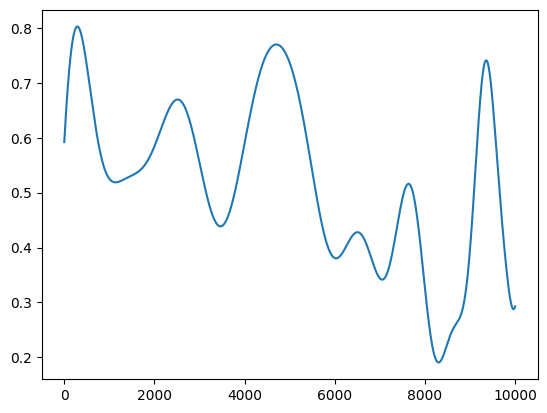

In [158]:
degree = 110
timepoints = 10000
a = 2
b = degree - 6

# random_signal = np.random.randn(degree)
random_signal = np.random.random(degree)
p = np.poly1d(np.polyfit(np.arange(len(random_signal)), random_signal, degree)) # find a polynomial of the same degree to fit the random signal exactly and create a poly1d function out of it
# p = np.poly1d(z)
x = np.linspace(a,b,timepoints) # create more points within the fitted range (end-1) to evaluate the polynomial function at -> get a smooth signal
w_vest = p(x)
plt.plot(np.arange(len(w_vest)), w_vest)
plt.show()

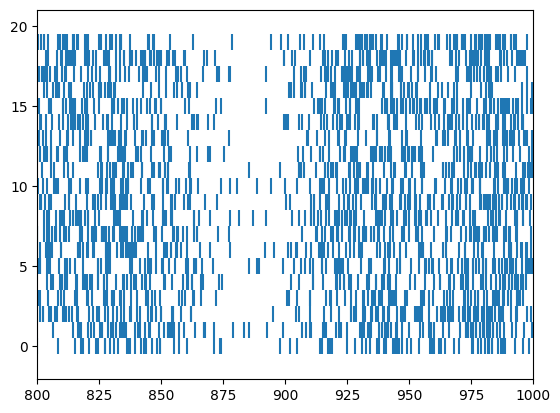

In [157]:
# Poisson FR generator
# Source: https://github.com/btel/python-in-neuroscience-tutorials/blob/master/poisson_process.ipynb

def inhomogeneous_poisson(rate, bin_size):
    n_bins = len(rate)
    spikes = np.random.rand(n_bins) < rate * bin_size
    spike_times = np.nonzero(spikes)[0] * bin_size
    return spike_times

def inhomogeneous_poisson_generator(n_trials, rate, bin_size):
    for i in range(n_trials):
        yield inhomogeneous_poisson(rate, bin_size)

spike_times = list(inhomogeneous_poisson_generator(n_trials=20, rate=w_vest, bin_size=0.1))

plt.eventplot(spike_times)
plt.xlim([800,1000])
plt.show()

### simple sine inputs

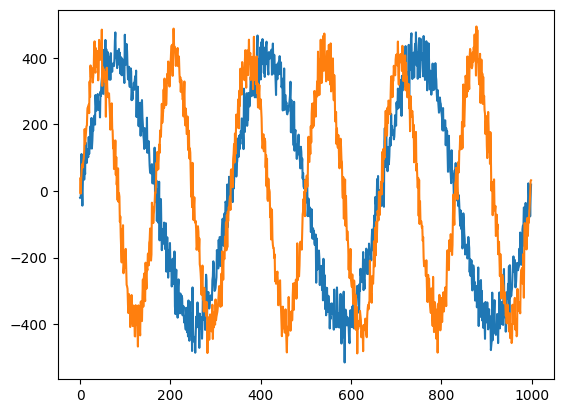

In [266]:
def get_two_sines(size, base_freq, coupling=1, amplitude=400, length=1):
    t = np.linspace(0,length,size)
    f1 = base_freq
    f2 = f1 * coupling
    w1 = 2 * np.pi * f1
    w2 = 2 * np.pi * f2
    
    noise1 = 0.1 * amplitude * np.random.normal(size=size)
    noise2 = 0.1 * amplitude * np.random.normal(size=size)
    
    sine1 = amplitude * np.sin(w1 * t) + noise1
    sine2 = amplitude * np.sin(w2 * t) + noise2
    
    return sine1, sine2

signal1, signal2 = get_two_sines(1000, 3, coupling=2)
plt.plot(signal1)
plt.plot(signal2)
plt.show()

In [231]:
np.vstack([signal1, signal2]).shape

(2, 1000)

### save mat

In [315]:
input_mat = {}
input_mat['__header__'] = "b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Apr 16 14:55:14 2024'"
input_mat['__version__'] = "1.0"
input_mat['__globals__'] = []

In [316]:
coupling = 2

# constructing inputs with different frequencies, numbers of sampels, the same coupling

freqs = np.linspace(0.5,30,Nit) # see the input generation matlab code (if (mod(i-2,Ntime)==0)) ~ line 90 Learning.m
np.random.shuffle(freqs)
input_mat['Inputs'] = np.array([np.vstack(get_two_sines(1000, f, coupling=coupling)) for f in freqs])
input_mat['InputL'] = np.array(get_two_sines(50000, 5, coupling=coupling, amplitude=120))
freqs = np.linspace(2,12,10)
np.random.shuffle(freqs)
input_mat['InputTs'] = np.array([np.vstack(get_two_sines(10000, f, coupling=coupling)) for f in freqs])

In [317]:
savemat(str(Path.home()/f'RANCZLAB-NAS/iakov/deneve_net/inputs_coupling_{coupling}.mat'), input_mat)

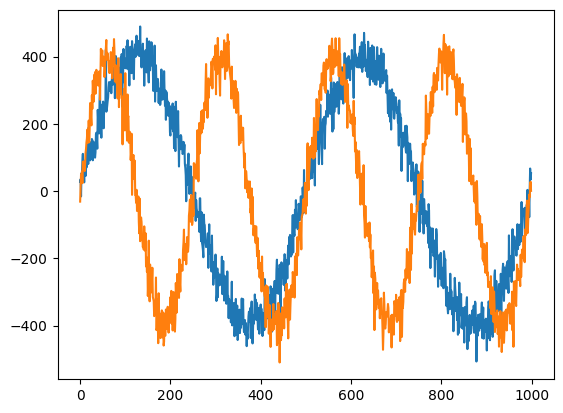

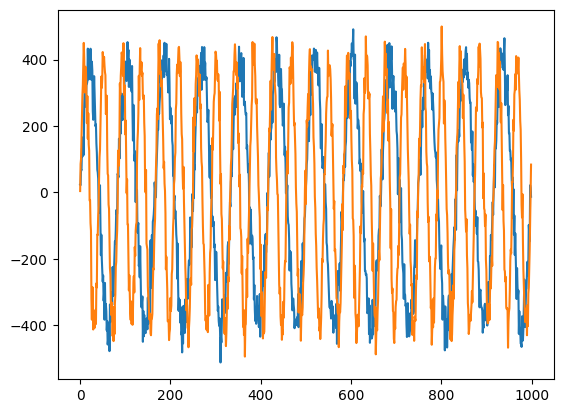

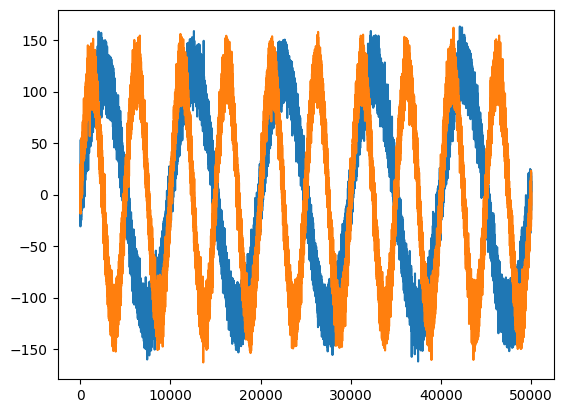

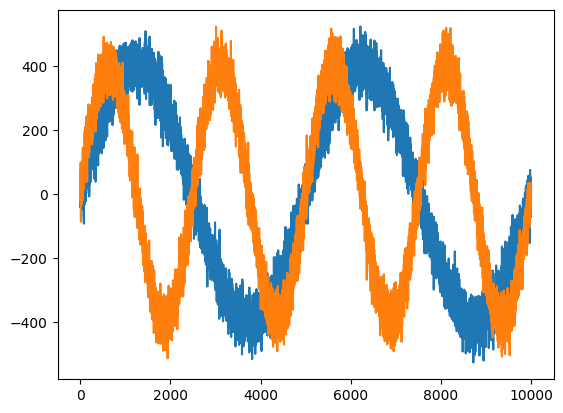

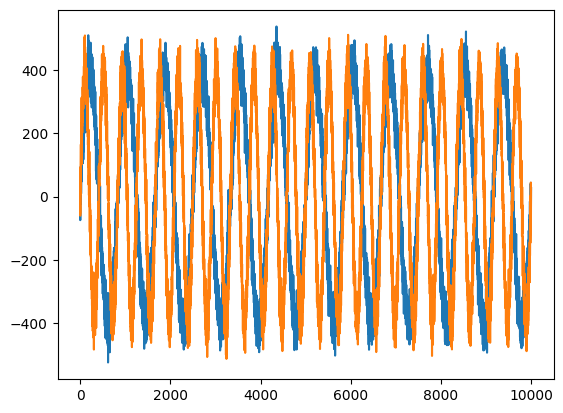

In [297]:
plt.plot(input_mat['Inputs'][0,0])
plt.plot(input_mat['Inputs'][0,1])
plt.show()
plt.plot(input_mat['Inputs'][22,0])
plt.plot(input_mat['Inputs'][22,1])
plt.show()
plt.plot(input_mat['InputL'][0])
plt.plot(input_mat['InputL'][1])
plt.show()
plt.plot(input_mat['InputTs'][0,0])
plt.plot(input_mat['InputTs'][0,1])
plt.show()
plt.plot(input_mat['InputTs'][9,0])
plt.plot(input_mat['InputTs'][9,1])
plt.show()

## inference

In [3]:
# Matlab code translated to Python
def runnet(dt, lmbda, F, Input, C, Nneuron, Ntime, Thresh):
    # Initialize arrays
    rO = np.zeros((Nneuron, Ntime))  # filtered spike trains
    O = np.zeros((Nneuron, Ntime))   # spike trains array
    V = np.zeros((Nneuron, Ntime))   # membrane potential array
    
    for t in range(1, Ntime):
        # Update membrane potential
        V[:, t] = (1 - lmbda * dt) * V[:, t - 1] + dt * np.dot(F.T, Input[:, t - 1]) + np.dot(C, O[:, t - 1]) + 0.001 * np.random.randn(Nneuron)
        
        # Find neuron with largest membrane potential
        k = np.argmax(V[:, t] - Thresh - 0.01 * np.random.randn(Nneuron))
        
        # If membrane potential exceeds threshold, neuron k spikes
        if V[k, t] >= 0:
            O[k, t] = 1
        
        # Filter spikes
        rO[:, t] = (1 - lmbda * dt) * rO[:, t - 1] + O[:, t]
    
    return rO, O, V


In [6]:
path = Path.home()/'output.mat'
matfile = loadmat(str(path))
print(matfile.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Nneuron', 'Nx', 'dt', 'lambda', 'epsr', 'epsf', 'alpha', 'beta', 'mu', 'Thresh', 'save_path', 'Fs', 'Cs', 'F', 'C', 'Decs', 'ErrorC', 'Inputs', 'InputL', 'InputTs', 'Fi', 'Ci'])


In [173]:
matfile['InputL'].max()

207.30136118217692

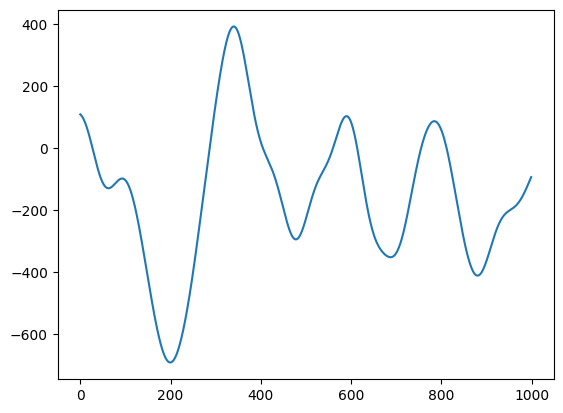

In [163]:
plt.plot(matfile['Inputs'][1,0])
# plt.plot(matfile['InputL'][0,:1000])
# plt.plot(matfile['InputTs'][0,0,:1000])
plt.show()

In [5]:
Nneuron = 20
Nx = 2
lmbda = 50
dt = 0.001
epsr = 0.001
epsf = 0.0001
alpha = 0.18
beta = 1/0.9
mu = 0.02/0.9
Thresh = 0.5

In [7]:
rO, O, V = runnet(dt,lmbda, matfile['F'], matfile['Inputs'][-1], matfile['C'], Nneuron, matfile['Inputs'].shape[-1], Thresh)
print(rO.shape, O.shape, V.shape)

(20, 1000) (20, 1000) (20, 1000)


In [48]:
def convert_to_eventplot(arr):
    return [list(np.where(arr[i] >= 1)[0]) for i in range(arr.shape[0])]

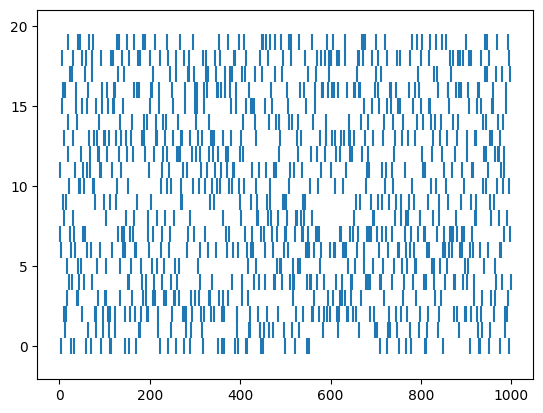

In [49]:
plt.eventplot(convert_to_eventplot(O))
plt.show()

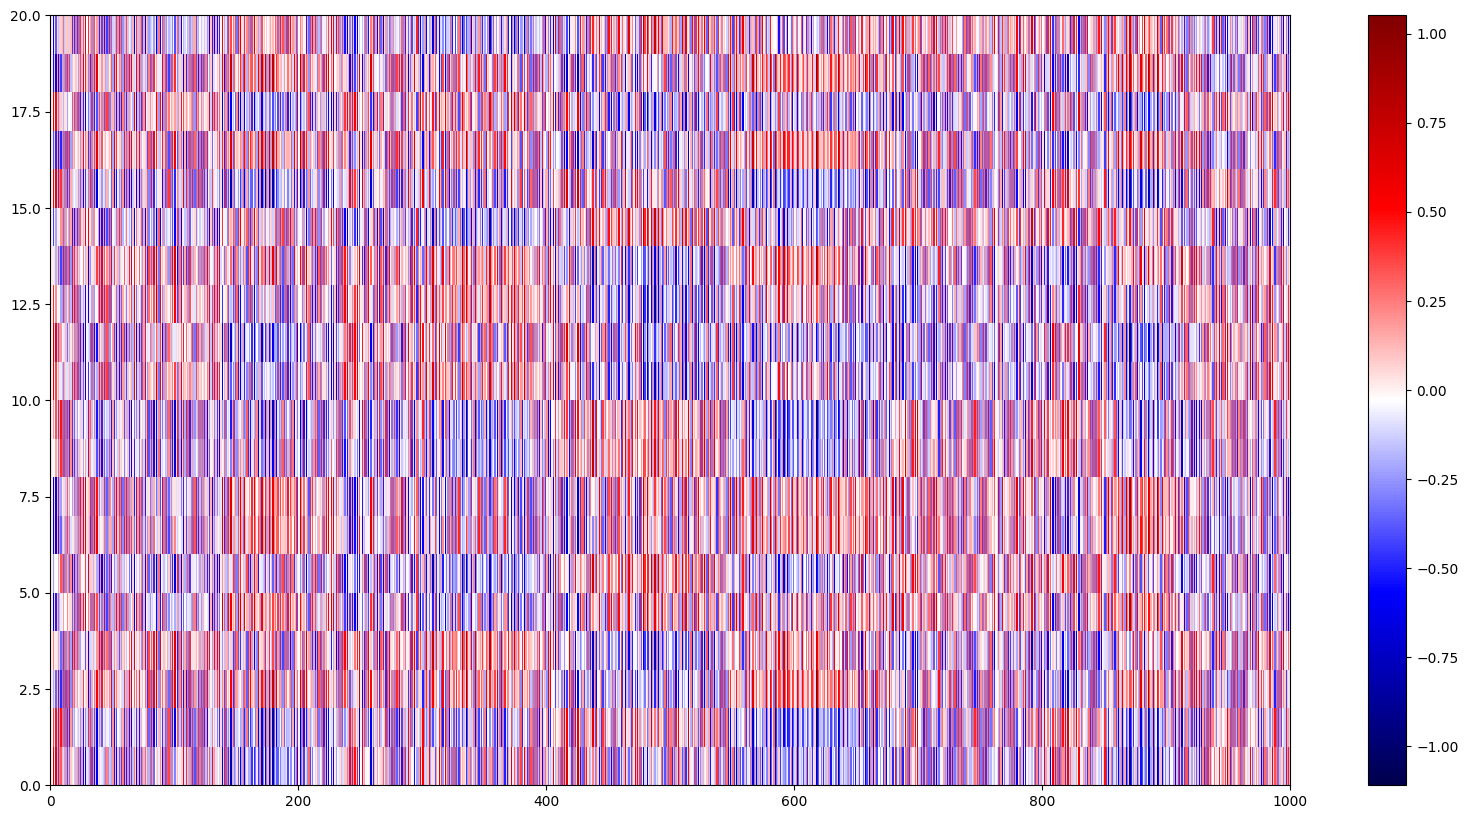

In [45]:
plt.figure(figsize=(20,10))
plt.pcolormesh(V, cmap='seismic')
plt.colorbar()
plt.show()

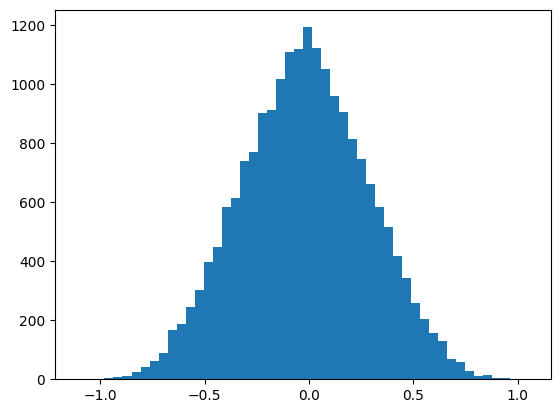

In [50]:
plt.hist(V.flatten(), bins=50)
plt.show()